# Churn-Scoring Analyse für B2B-Glasfaser Kunden

## Einführung
Diese Fallstudie entwickelt ein automatisiertes System zur Identifikation von Kunden mit hohem Churn-Risiko im B2B-Glasfasergeschäft. Das System berechnet für jeden Kunden einen Churn-Score (0-100) basierend auf technischen, nutzungsbezogenen und vertraglichen Kennzahlen.

## 1. Datenimport und Initialisierung

In [ ]:
# Imports, Anzeigeeinstellungen und zentrale Konfiguration
# Erklärung:
# - Hier importieren wir alle benötigten Bibliotheken.
# - Wir definieren zentrale Konstanten (WEIGHTS, THRESHOLDS, REFERENCE_DATE). Diese Parameter können leicht angepasst werden, um den Output zu verändern

import os
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Anzeigeoptionen für pandas (bessere Lesbarkeit im Notebook)
pd.set_option('display.max_columns', None) # Anzeige aller Spalten im Notebook eines DataFrames an
pd.set_option('display.width', 140)
pd.set_option('display.float_format', '{:.2f}'.format) # Automatische Formatierung von Floats auf zwei Nachkommastellen

# Plot-Stil und 1&1 Corporate Colors
plt.style.use('seaborn-v0_8-whitegrid')
CORPORATE_COLORS = {
    'primary': '#003D8F',    # 1&1 Blau
    'secondary': '#000000',  # Schwarz
    'accent': '#666666',     # Grau
    'highlight': '#0071D9',  # Hellblau
    'success': '#2E8B57',    # Erfolgsgrün
    'warning': '#FF8C00',    # Warnorange
    'danger': '#DC143C'      # Rot für hohes Risiko
}
sns.set_palette([CORPORATE_COLORS['primary'], CORPORATE_COLORS['accent'], CORPORATE_COLORS['secondary']])

# Zentrale Definition der Gewichtung der vier Score‑Komponenten
WEIGHTS = { # In Summe 100%
    'stoerungen': 0.35,
    'vertragsende': 0.30,
    'nutzung': 0.20,
    'kundenzufriedenheit': 0.15
}
# Beispielhafte Schwellenwerte für die Analyse
THRESHOLDS = {
    'unterauslastung_pct': 30,   # Prozent‑Schwellenwert für die Bandbreitennutzung - Wenn ein Kunde weniger als 30 % nutzt, wird er als unterausgelastet markiert (Flag = 1)
    'kritisch_score': 75, # Wenn der Kunde ein Churn-Score >= 75 hat, gilt er als kritisch
    'hoch_score': 50 
}
REFERENCE_DATE = pd.Timestamp('2024-12-01')  # Bezugsdatum für verbleibende Laufzeit


## 2. Daten laden und erste Qualitätsprüfung

In [38]:
# Erklärung:
# - Wir laden die drei CSV-Dateien und prüfen kurz Zeilenanzahl, fehlende Werte und Duplikate.
# - Die Funktion check_data_quality gibt ein kleines Report-Dict zurück.

DATA_DIR = "CSV_Files"  # Pfad zu den generierten CSVs

# CSVs laden
contract_df = pd.read_csv(os.path.join(DATA_DIR, "contract_data.csv"), encoding="utf-8")
support_df = pd.read_csv(os.path.join(DATA_DIR, "support_data.csv"), encoding="utf-8")
usage_df = pd.read_csv(os.path.join(DATA_DIR, "usage_data.csv"), encoding="utf-8")

def check_data_quality(df, name):
    """Gibt grundlegende Qualitätsmetriken aus und returniert ein kleines Dict."""
    rows, cols = df.shape
    missing = df.isnull().sum().sum()
    duplicates = df.duplicated().sum()
    print(f"\nDatenqualität - {name}: Zeilen={rows}, Spalten={cols}, Fehlende Werte={missing}, Duplikate={duplicates}")
    return {'rows': rows, 'cols': cols, 'missing': missing, 'duplicates': duplicates}

quality_report = {
    'contract': check_data_quality(contract_df, "Vertragsdaten"),
    'support': check_data_quality(support_df, "Supportdaten"),
    'usage': check_data_quality(usage_df, "Nutzungsdaten")
}

# Erste Zeilen zur Kontrolle
print("\nVertragsdaten (erste 3 Zeilen):")
display(contract_df.head(3))
print("\nSupportdaten (erste 3 Zeilen):")
display(support_df.head(3))
print("\nNutzungsdaten (erste 3 Zeilen):")
display(usage_df.head(3))



Datenqualität - Vertragsdaten: Zeilen=1500, Spalten=6, Fehlende Werte=0, Duplikate=0

Datenqualität - Supportdaten: Zeilen=1500, Spalten=4, Fehlende Werte=0, Duplikate=0

Datenqualität - Nutzungsdaten: Zeilen=1500, Spalten=3, Fehlende Werte=0, Duplikate=0

Vertragsdaten (erste 3 Zeilen):


,ID,Branche,Unternehmensgröße,Vertragsbeginn,Laufzeit,monatliche_Grundgebühr
0,CUST0001,Handel,460,2023-05-17,36,2696
1,CUST0002,Öffentlicher Sektor,112,2025-05-21,36,2565
2,CUST0003,Gesundheit,11,2023-04-17,36,617



Supportdaten (erste 3 Zeilen):


,ID,Anzahl_technischer_Stoerungen_letzte_6M,avg_Dauer_Entstoerung_Std,Anzahl_Beschwerdeanrufe
0,CUST0001,0,0.00,0
1,CUST0002,1,4.30,1
2,CUST0003,3,6.60,2



Nutzungsdaten (erste 3 Zeilen):


,ID,durchschnittliche_Bandbreitennutzung_pct,Anzahl_Peaks
0,CUST0001,59.10,4
1,CUST0002,61.00,1
2,CUST0003,32.30,1


## 3. Datenbereinigung und Vorverarbeitung

In [ ]:
# Zelle 3: Datentypen, Bereinigung und Merge
# Erklärung:
# - Wir stellen sicher, dass Datums- und numerische Spalten korrekte Typen haben.
# - Fehlende numerische Werte werden mit 0 ersetzt.
# - Unternehmensgröße darf nicht 0 sein, um Division durch 0 zu vermeiden.
# - Anschließend Merge der drei Tabellen auf Basis des Keys "ID".

# Vertragsbeginn als Datum parsen (ungültige Werte -> NaT)
contract_df['Vertragsbeginn'] = pd.to_datetime(contract_df['Vertragsbeginn'], errors='coerce')

# Einheitliche Spaltennamen
if 'monatliche_Grundgebühr' in contract_df.columns:
    contract_df = contract_df.rename(columns={'monatliche_Grundgebühr': 'monatliche_Grundgebuehr'})

# Numerische Spalten robust konvertieren und NaNs füllen
numeric_cols = [
    'Unternehmensgröße', 'monatliche_Grundgebuehr',
    'Anzahl_technischer_Stoerungen_letzte_6M', 'Anzahl_Beschwerdeanrufe',
    'Anzahl_Peaks', 'durchschnittliche_Bandbreitennutzung_pct'
]
for col in numeric_cols:
    # Wenn Spalte existiert, konvertiere und fülle NaN mit 0 (oder 1 für Unternehmensgröße)
    if col in contract_df.columns:
        contract_df[col] = pd.to_numeric(contract_df[col], errors='coerce')
    if col in support_df.columns:
        support_df[col] = pd.to_numeric(support_df[col], errors='coerce')
    if col in usage_df.columns:
        usage_df[col] = pd.to_numeric(usage_df[col], errors='coerce')

# Fülle NaNs und sichere Unternehmensgröße
if 'Unternehmensgröße' in contract_df.columns:
    contract_df['Unternehmensgröße'] = contract_df['Unternehmensgröße'].fillna(1).clip(lower=1)
# Für andere numerische Spalten: fülle NaN mit 0 in allen DataFrames
for df_tmp in [contract_df, support_df, usage_df]:
    for col in numeric_cols:
        if col in df_tmp.columns:
            df_tmp[col] = df_tmp[col].fillna(0)

# Merge: left join, damit alle Vertragsdaten erhalten bleiben
df = contract_df.merge(support_df, on='ID', how='left').merge(usage_df, on='ID', how='left')

# Nach dem Merge: fehlende numerische Werte nochmals füllen (Sicherheit)
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

print(f"Zusammengeführter Datensatz: {df.shape[0]} Zeilen, {df.shape[1]} Spalten")
print("\nErsten 5 Zeilen des zusammengeführten Datensatzes:")
display(df.head())


Zusammengeführter Datensatz: 1500 Zeilen, 11 Spalten

Ersten 5 Zeilen des zusammengeführten Datensatzes:


,ID,Branche,Unternehmensgröße,Vertragsbeginn,Laufzeit,monatliche_Grundgebuehr,Anzahl_technischer_Stoerungen_letzte_6M,avg_Dauer_Entstoerung_Std,Anzahl_Beschwerdeanrufe,durchschnittliche_Bandbreitennutzung_pct,Anzahl_Peaks
0,CUST0001,Handel,460,2023-05-17,36,2696,0,0.00,0,59.10,4
1,CUST0002,Öffentlicher Sektor,112,2025-05-21,36,2565,1,4.30,1,61.00,1
2,CUST0003,Gesundheit,11,2023-04-17,36,617,3,6.60,2,32.30,1
3,CUST0004,Öffentlicher Sektor,112,2024-04-15,36,2888,1,3.90,1,61.40,2
4,CUST0005,IT,12,2024-08-30,24,609,1,2.80,1,39.40,1


## 4. Erste Explorative Datenanalyse
*Hinweis*: Bewusst kurz gehalten, da es sich um von mir selbst erstellte synthestische Daten handelt

In [40]:
# Erklärung:
# - Wir zeigen beschreibende Statistiken für numerische Spalten.
# - Zusätzlich prüfen wir auf offensichtliche Ausreißer (z. B. extrem hohe Gebühren).

numeric_cols_df = df.select_dtypes(include=[np.number]).columns.tolist()
print("Numerische Spalten:", numeric_cols_df)

# Descriptive Statistik
display(df[numeric_cols_df].describe().round(2))

# Beispielhafte einfache Ausreißer-Checks (Beispiele)
print("\nMaximale monatliche Grundgebühr:", df['monatliche_Grundgebuehr'].max())
print("Anzahl Kunden mit sehr niedriger Nutzung (<5%):", (df['durchschnittliche_Bandbreitennutzung_pct'] < 5).sum())
print("Anzahl Kunden mit sehr vielen Störungen (>10 in 6M):", (df['Anzahl_technischer_Stoerungen_letzte_6M'] > 10).sum())


Numerische Spalten: ['Unternehmensgröße', 'Laufzeit', 'monatliche_Grundgebuehr', 'Anzahl_technischer_Stoerungen_letzte_6M', 'avg_Dauer_Entstoerung_Std', 'Anzahl_Beschwerdeanrufe', 'durchschnittliche_Bandbreitennutzung_pct', 'Anzahl_Peaks']


,Unternehmensgröße,Laufzeit,monatliche_Grundgebuehr,Anzahl_technischer_Stoerungen_letzte_6M,avg_Dauer_Entstoerung_Std,Anzahl_Beschwerdeanrufe,durchschnittliche_Bandbreitennutzung_pct,Anzahl_Peaks
count,1500.00,1500.00,1500.00,1500.00,1500.00,1500.00,1500.00,1500.00
mean,83.25,31.56,1450.10,2.15,4.57,1.15,51.09,2.32
std,128.89,5.80,1649.52,1.60,2.74,1.03,19.15,2.23
min,4.00,24.00,131.00,0.00,0.00,0.00,5.00,0.00
25%,12.00,24.00,434.00,1.00,2.80,0.00,38.50,1.00
50%,16.00,36.00,731.50,2.00,4.90,1.00,50.95,2.00
75%,109.00,36.00,1916.25,3.00,6.52,2.00,64.40,3.00
max,488.00,36.00,9221.00,10.00,11.30,5.00,100.00,13.00



Maximale monatliche Grundgebühr: 9221
Anzahl Kunden mit sehr niedriger Nutzung (<5%): 0
Anzahl Kunden mit sehr vielen Störungen (>10 in 6M): 0


## 5. Berechnung Vertragsende und verbleibende Laufzeit

In [ ]:
# Erklärung:
# - Wir verwenden eine einfache Annahme: 1 Monat = 30 Tage
# - Berechne Vertragsende und verbleibende Tage/Monate relativ zum REFERENCE_DATE.

def add_months_as_30days(date, months):
    """
    Addiert 'months' * 30 Tage zu einem pandas Timestamp.
    - Wenn date NaT ist, wird NaT zurückgegeben.
    """
    if pd.isna(date):
        return pd.NaT
    return date + pd.to_timedelta(int(months) * 30, unit='D') # Zeitspanne in Tagen

# Vertragsende = Vertragsbeginn + Laufzeit (in Monaten)
df['Vertragsende'] = df.apply(
    lambda r: add_months_as_30days(r['Vertragsbeginn'], r['Laufzeit']) if pd.notna(r['Vertragsbeginn']) else pd.NaT,
    axis=1
)

# verbleibende Tage und Monate relativ zum REFERENCE_DATE
df['verbleibende_Tage'] = (df['Vertragsende'] - REFERENCE_DATE).dt.days
# Wir teilen durch 30.44 (mittlere Tage pro Monat) für etwas genauere Umrechnung
df['verbleibende_Monate'] = (df['verbleibende_Tage'] / 30).clip(lower=-9999).round(1) # clip(lower=-9999) als Schutz vor Extremwerten

# Flags für kritische Zeitfenster
df['vertragsende_unter_6_monaten'] = (df['verbleibende_Monate'] < 6).astype(int)
df['vertragsende_unter_3_monaten'] = (df['verbleibende_Monate'] < 3).astype(int)
df['vertrag_bereits_abgelaufen'] = (df['verbleibende_Tage'] < 0).astype(int)

# Kurzer Check
display(df[['ID', 'Vertragsbeginn', 'Laufzeit', 'Vertragsende', 'verbleibende_Monate']].head())


,ID,Vertragsbeginn,Laufzeit,Vertragsende,verbleibende_Monate
0,CUST0001,2023-05-17,36,2026-05-01,17.00
1,CUST0002,2025-05-21,36,2028-05-05,41.10
2,CUST0003,2023-04-17,36,2026-04-01,16.00
3,CUST0004,2024-04-15,36,2027-03-31,27.90
4,CUST0005,2024-08-30,24,2026-08-20,20.60


## 6. Feature Engineering
Zweck: Relevante Features erstellen: Störungen pro 100 MA, Proxy für 2‑Monats‑Störungen, Unterauslastung, Peak‑Verhältnis, Kosten pro MA.

In [ ]:
# Erklärung:
# - Wir erstellen normalisierte und erklärbare Features, die in den Score eingehen.

# 1) Störungen pro 100 Mitarbeiter (normiert)
'''
Normalisierung nach Unternehmensgröße macht Störungsraten vergleichbar zwischen kleinen und großen Kunden. 
Ein kleiner Kunde mit 5 Störungen ist anders zu bewerten als ein Konzern mit 5 Störungen
'''
df['Stoerungen_pro_100_MA'] = (df['Anzahl_technischer_Stoerungen_letzte_6M'] / df['Unternehmensgröße']) * 100
df['Stoerungen_pro_100_MA'] = df['Stoerungen_pro_100_MA'].replace([np.inf, -np.inf], 0).fillna(0)

# 2) Proxy: Störungen in den letzten 2 Monaten (Annahme: 2/6 = 2 Monate der 6M-Aggregate)
'''
Normalisierung nach Unternehmensgröße macht Störungsraten vergleichbar zwischen kleinen und großen Kunden. 
Ein kleiner Kunde mit 5 Störungen ist anders zu bewerten als ein Konzern mit 5 Störungen
'''
df['Stoerungen_letzte_2M'] = (df['Anzahl_technischer_Stoerungen_letzte_6M'] * (2/6)).round().astype(int)

# 3) Unterauslastung-Flag (Schwelle aus THRESHOLDS -> Ergebnis Binär (Ja/Nein))
df['Unterauslastung_Flag'] = (df['durchschnittliche_Bandbreitennutzung_pct'] < THRESHOLDS['unterauslastung_pct']).astype(int)

# 4) Peak-Verhältnis
'''
Gibt nach Normierung auf Max-Wert die relative Peak-Intensität an 
Nützlich, um Kunden mit ungewöhnlich vielen Lastspitzen zu identifizieren, die technische Ursachen haben könnten.
'''
max_peaks = df['Anzahl_Peaks'].max() if df['Anzahl_Peaks'].max() > 0 else 1
df['Peak_Verhaeltnis'] = (df['Anzahl_Peaks'] / max_peaks).fillna(0)

# 5) Stoerungen pro Peak (Hinweis: wenn Peaks 0, dann verwenden wir absolute Störungen)
'''
Misst, ob Störungen mit Peaks korrelieren
Viele Störungen bei wenigen Peaks deuten auf persistente Probleme; viele Peaks mit wenigen Störungen deuten auf kurzzeitige Lastspitzen.
'''
df['Stoerungen_pro_Peak'] = df.apply(
    lambda r: (r['Anzahl_technischer_Stoerungen_letzte_6M'] / r['Anzahl_Peaks']) if r['Anzahl_Peaks'] > 0 else r['Anzahl_technischer_Stoerungen_letzte_6M'],
    axis=1
)

# 6) Wirtschaftliche Features: Kosten pro Mitarbeiter und Kosteneffizienz
df['kosten_pro_mitarbeiter'] = (df['monatliche_Grundgebuehr'] / df['Unternehmensgröße']).replace([np.inf, -np.inf], 0).fillna(0)
df['kosteneffizienz'] = df['durchschnittliche_Bandbreitennutzung_pct'] / (df['monatliche_Grundgebuehr'] + 1) # Kosteneffizienz verbindet Nutzung und Preis und hilf somit, Kunden zu priorisieren, bei denen ein wirtschaftlicher Hebel besteht.

# Überblick
display(df[[
    'ID', 'Unternehmensgröße', 'Anzahl_technischer_Stoerungen_letzte_6M',
    'Stoerungen_pro_100_MA', 'Stoerungen_letzte_2M', 'Unterauslastung_Flag',
    'Anzahl_Peaks', 'Peak_Verhaeltnis', 'Stoerungen_pro_Peak',
    'kosten_pro_mitarbeiter', 'kosteneffizienz'
]].head())


,ID,Unternehmensgröße,Anzahl_technischer_Stoerungen_letzte_6M,Stoerungen_pro_100_MA,Stoerungen_letzte_2M,Unterauslastung_Flag,Anzahl_Peaks,Peak_Verhaeltnis,Stoerungen_pro_Peak,kosten_pro_mitarbeiter,kosteneffizienz
0,CUST0001,460,0,0.00,0,0,4,0.31,0.00,5.86,0.02
1,CUST0002,112,1,0.89,0,0,1,0.08,1.00,22.90,0.02
2,CUST0003,11,3,27.27,1,0,1,0.08,3.00,56.09,0.05
3,CUST0004,112,1,0.89,0,0,2,0.15,0.50,25.79,0.02
4,CUST0005,12,1,8.33,0,0,1,0.08,1.00,50.75,0.06


## 7. Normalisierung & Churn‑Score
Zweck: Min‑Max‑Normalisierung auf 0–100, Komponenten berechnen, gewichtete Summe (Score 0–100), Risikokategorien.

In [ ]:
# Erklärung:
# - Min-Max-Normalisierung auf 0-100 für numerische Signale.
# - Komponenten bilden und mit WEIGHTS gewichten. Ergebnis ist 0-100.

def minmax_0_100(series, invertieren=False):
    """
    Min-Max-Skalierung auf 0-100. Bei konstanter Serie -> 50 (neutral)
    """
    s = series.fillna(series.min())
    min_val = s.min()
    max_val = s.max()
    if min_val == max_val:
        return pd.Series(50.0, index=series.index) # Bei konstanter Serie (min == max) gibt die Funktion neutralen Wert 50 zurück, damit die Komponente weder positiv noch negativ verzerrt.
    scaled = (s - min_val) / (max_val - min_val) * 100
    return 100 - scaled if invertieren else scaled

# Normalisiere relevante Signale
df['norm_Stoerungen_pro_100_MA'] = minmax_0_100(df['Stoerungen_pro_100_MA'])
df['norm_Stoerungen_letzte_2M'] = minmax_0_100(df['Stoerungen_letzte_2M'])
df['norm_Peak_Verhaeltnis'] = minmax_0_100(df['Peak_Verhaeltnis'])
df['norm_Stoerungen_pro_Peak'] = minmax_0_100(df['Stoerungen_pro_Peak'])
# Für verbleibende Monate invertieren: weniger Monate -> höheres Risiko
df['norm_verbleibende_monate_inv'] = minmax_0_100(df['verbleibende_Monate'], invertieren=True) # wird invertiert skaliert, weil weniger verbleibende Monate ein höheres Risiko bedeuten.

# Diskrete Flags auf 0-100, damit sie mit den anderen Werten vergleichbar sind
df['flag_Unterauslastung_100'] = df['Unterauslastung_Flag'] * 100
df['flag_Vertrag_endet_in_weniger_als_6M_100'] = df['vertragsende_unter_6_monaten'] * 100

# Komponenten (alle 0-100)
df['komponente_stoerungen'] = df['norm_Stoerungen_letzte_2M'] * 0.6 + df['norm_Stoerungen_pro_Peak'] * 0.4 # Häufige Störungen sind das stärkste Signal für Unzufriedenheit -> höherer Anteil (60%). Viele Peaks mit wenigen Störungen ist weniger alarmierend als viele Störungen ohne Peaks.
df['komponente_vertragsende'] = df['norm_verbleibende_monate_inv'] * 0.7 + df['flag_Vertrag_endet_in_weniger_als_6M_100'] * 0.3 # Kontinuierliches Signal (verbleibende Monate) liefert feinere Abstufung , deswegen 70% Das Flag ist ein starker, diskreter Hinweis auf unmittelbares Risiko -> 30%.
df['komponente_nutzung'] = df['flag_Unterauslastung_100']
df['komponente_kundenzufriedenheit'] = minmax_0_100(df['Anzahl_Beschwerdeanrufe'])

# Rohscore: gewichtete Summe (Gewichte aus WEIGHTS, Summe = 1)
df['churn_score_raw'] = (
    WEIGHTS['stoerungen'] * df['komponente_stoerungen'] +
    WEIGHTS['vertragsende'] * df['komponente_vertragsende'] +
    WEIGHTS['nutzung'] * df['komponente_nutzung'] +
    WEIGHTS['kundenzufriedenheit'] * df['komponente_kundenzufriedenheit']
)

# Score 0-100, gerundet
df['churn_score'] = df['churn_score_raw'].clip(lower=0, upper=100).round(1)

# Risikokategorien bestimmen
def bestimme_risikokategorie(score):
    if score >= THRESHOLDS['kritisch_score']:
        return 'Kritisch'
    elif score >= THRESHOLDS['hoch_score']:
        return 'Hoch'
    elif score >= 25:
        return 'Mittel'
    else:
        return 'Niedrig'

df['risikokategorie'] = df['churn_score'].apply(bestimme_risikokategorie)

# Priorität: Score gewichtet mit Umsatz
'''
einfache Heuristik, die Risiko mit Umsatz kombiniert, damit Customer Success zuerst wirtschaftlich relevante Fälle bearbeitet.
'''
df['monatliche_Grundgebuehr'] = pd.to_numeric(df['monatliche_Grundgebuehr'], errors='coerce').fillna(0)
df['prioritaet'] = (df['churn_score'] * df['monatliche_Grundgebuehr'] / 1000).round(2)

# Kontrolle: Top 5
display(df.sort_values('churn_score', ascending=False)[[
    'ID', 'churn_score', 'risikokategorie', 'Vertragsende', 'verbleibende_Monate',
    'Anzahl_technischer_Stoerungen_letzte_6M', 'durchschnittliche_Bandbreitennutzung_pct'
]].head(5))


,ID,churn_score,risikokategorie,Vertragsende,verbleibende_Monate,Anzahl_technischer_Stoerungen_letzte_6M,durchschnittliche_Bandbreitennutzung_pct
460,CUST0461,83.90,Kritisch,2025-04-07,4.20,7,17.90
775,CUST0776,77.10,Kritisch,2025-01-23,1.70,5,19.90
708,CUST0709,75.20,Kritisch,2025-02-11,2.40,5,24.20
264,CUST0265,74.70,Hoch,2025-03-18,3.50,5,14.90
818,CUST0819,69.30,Hoch,2025-05-16,5.50,3,5.00


## 8. Validierung & Sensitivitätsanalyse
Zweck: Score‑Verteilung prüfen, Top‑5 stabilität bei Gewichtsänderungen testen.

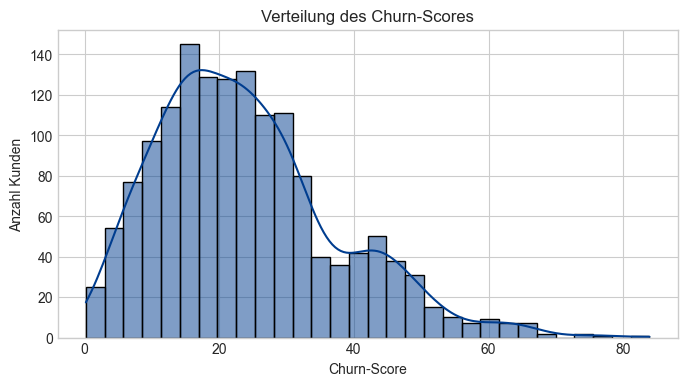

Baseline Top-5: ['CUST0461', 'CUST0776', 'CUST0709', 'CUST0265', 'CUST0819']
Variante Top-5: ['CUST0461', 'CUST0776', 'CUST0709', 'CUST0265', 'CUST0080']
Stabile IDs in beiden Top-5: {'CUST0265', 'CUST0709', 'CUST0461', 'CUST0776'}


In [ ]:
# Erklärung:
# - Wir visualisieren die Score-Verteilung und prüfen, ob Top-Kunden stabil bleiben,
#   wenn Gewichte leicht variiert werden.

import matplotlib.pyplot as plt
import seaborn as sns

# 1) Verteilung des Churn-Scores
plt.figure(figsize=(8,4))
sns.histplot(df['churn_score'], bins=30, kde=True, color=CORPORATE_COLORS['primary'])
plt.title('Verteilung des Churn-Scores')
plt.xlabel('Churn-Score')
plt.ylabel('Anzahl Kunden')
plt.show()

# 2) Top-5 IDs (Baseline)
baseline_top5 = df.sort_values('churn_score', ascending=False).head(5)['ID'].tolist()

# 3) Sensitivitätsanalyse: Stoerungen +10%, Vertragsende -10%
'''
Zweck: erhöht das Gewicht für Störungen um 10% und reduziert das für Vertragsende um 10%, normalisiert dann so, dass die Gewichte wieder auf 1 summieren
So bleibt die Gesamt-Skalierung des Scores konsistent.
'''
w_s = WEIGHTS['stoerungen'] * 1.1
w_v = WEIGHTS['vertragsende'] * 0.9
w_n = WEIGHTS['nutzung']
w_k = WEIGHTS['kundenzufriedenheit']
# Normiere die Gewichte so, dass sie wieder 1 ergeben
w_sum = w_s + w_v + w_n + w_k
w_s, w_v, w_n, w_k = w_s/w_sum, w_v/w_sum, w_n/w_sum, w_k/w_sum

# Berechne Variante-Score (nur temporär)
df['score_variant'] = (
    w_s * df['komponente_stoerungen'] +
    w_v * df['komponente_vertragsende'] +
    w_n * df['komponente_nutzung'] +
    w_k * df['komponente_kundenzufriedenheit']
)
variant_top5 = df.sort_values('score_variant', ascending=False).head(5)['ID'].tolist()

print("Baseline Top-5:", baseline_top5)
print("Variante Top-5:", variant_top5)
print("Stabile IDs in beiden Top-5:", set(baseline_top5).intersection(set(variant_top5)))


## 9. Branchenanalyse


ANALYSE NACH BRANCHEN

1. Durchschnittlicher Churn-Score pro Branche (absteigend):


,mean,std,count
Branche,,,
IT,25.04,13.60,323
Handel,25.01,14.60,317
Industrie,24.55,12.84,211
Finanzen,23.55,13.10,289
Öffentlicher Sektor,23.32,15.54,61
Gesundheit,23.21,13.17,198
Medien,20.48,10.30,101



2. Risikoverteilung pro Branche (in %):


risikokategorie,Hoch,Kritisch,Mittel,Niedrig
Branche,,,,
Finanzen,2.40,0.00,39.40,58.10
Gesundheit,4.50,0.00,34.80,60.60
Handel,6.00,0.60,35.60,57.70
IT,5.00,0.00,38.40,56.70
Industrie,3.80,0.00,39.30,56.90
Medien,0.00,0.00,30.70,69.30
Öffentlicher Sektor,3.30,1.60,31.10,63.90


<Figure size 1200x600 with 0 Axes>

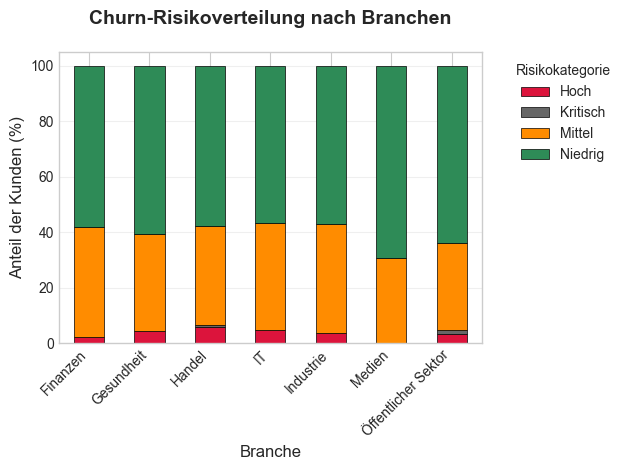


3. Top 3 Branchen mit höchstem durchschnittlichem Churn-Score:
  1. IT: 25.0 Punkte (n=323.0 Kunden)
  2. Handel: 25.0 Punkte (n=317.0 Kunden)
  3. Industrie: 24.5 Punkte (n=211.0 Kunden)


In [ ]:
print("\n" + "="*80)
print("ANALYSE NACH BRANCHEN")
print("="*80)

# 1. Durchschnittlicher Churn-Score pro Branche
'''
Gruppiert die Daten nach Branche und berechnet für jede Branche den Durchschnitts-Score, die Standardabweichung und die Anzahl der Kunden.
Sortiert die Branchen absteigend nach dem Durchschnitts-Score, damit die risikoreichsten Branchen oben stehen.
'''
branchen_scores = df.groupby('Branche')['churn_score'].agg(['mean', 'std', 'count'])
branchen_scores = branchen_scores.sort_values('mean', ascending=False)

print("\n1. Durchschnittlicher Churn-Score pro Branche (absteigend):")
display(branchen_scores.round(2))

# 2. Risikokategorien pro Branche (Anteile in %)
'''
Erstellt eine Kreuztabelle, die für jede Branche den prozentualen Anteil der Kunden in jeder Risikokategorie (Niedrig, Mittel, Hoch, Kritisch) berechnet
normalize='index' sorgt dafür, dass die Zeilen (Branchen) auf 1 normiert werden; Multiplikation mit 100 wandelt die Werte in Prozent um.

'''
risiko_verteilung = pd.crosstab(
    df['Branche'], 
    df['risikokategorie'],
    normalize='index'
) * 100

print("\n2. Risikoverteilung pro Branche (in %):")
display(risiko_verteilung.round(1))

# 3. Visualisierung: Stacked Bar Chart pro Branche
plt.figure(figsize=(12, 6))
risiko_verteilung.plot(
    kind='bar',
    stacked=True,
    color=[CORPORATE_COLORS['danger'], CORPORATE_COLORS['accent'], 
           CORPORATE_COLORS['warning'], CORPORATE_COLORS['success']],
    edgecolor='black',
    linewidth=0.5
)

plt.title('Churn-Risikoverteilung nach Branchen', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Branche', fontsize=12)
plt.ylabel('Anteil der Kunden (%)', fontsize=12)
plt.legend(title='Risikokategorie', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 4. Top-Branchen mit höchstem Risiko
print("\n3. Top 3 Branchen mit höchstem durchschnittlichem Churn-Score:")
top_branchen = branchen_scores.head(3)
for i, (branche, row) in enumerate(top_branchen.iterrows(), 1):
    print(f"  {i}. {branche}: {row['mean']:.1f} Punkte (n={row['count']} Kunden)")

## 10. Visualisierungen

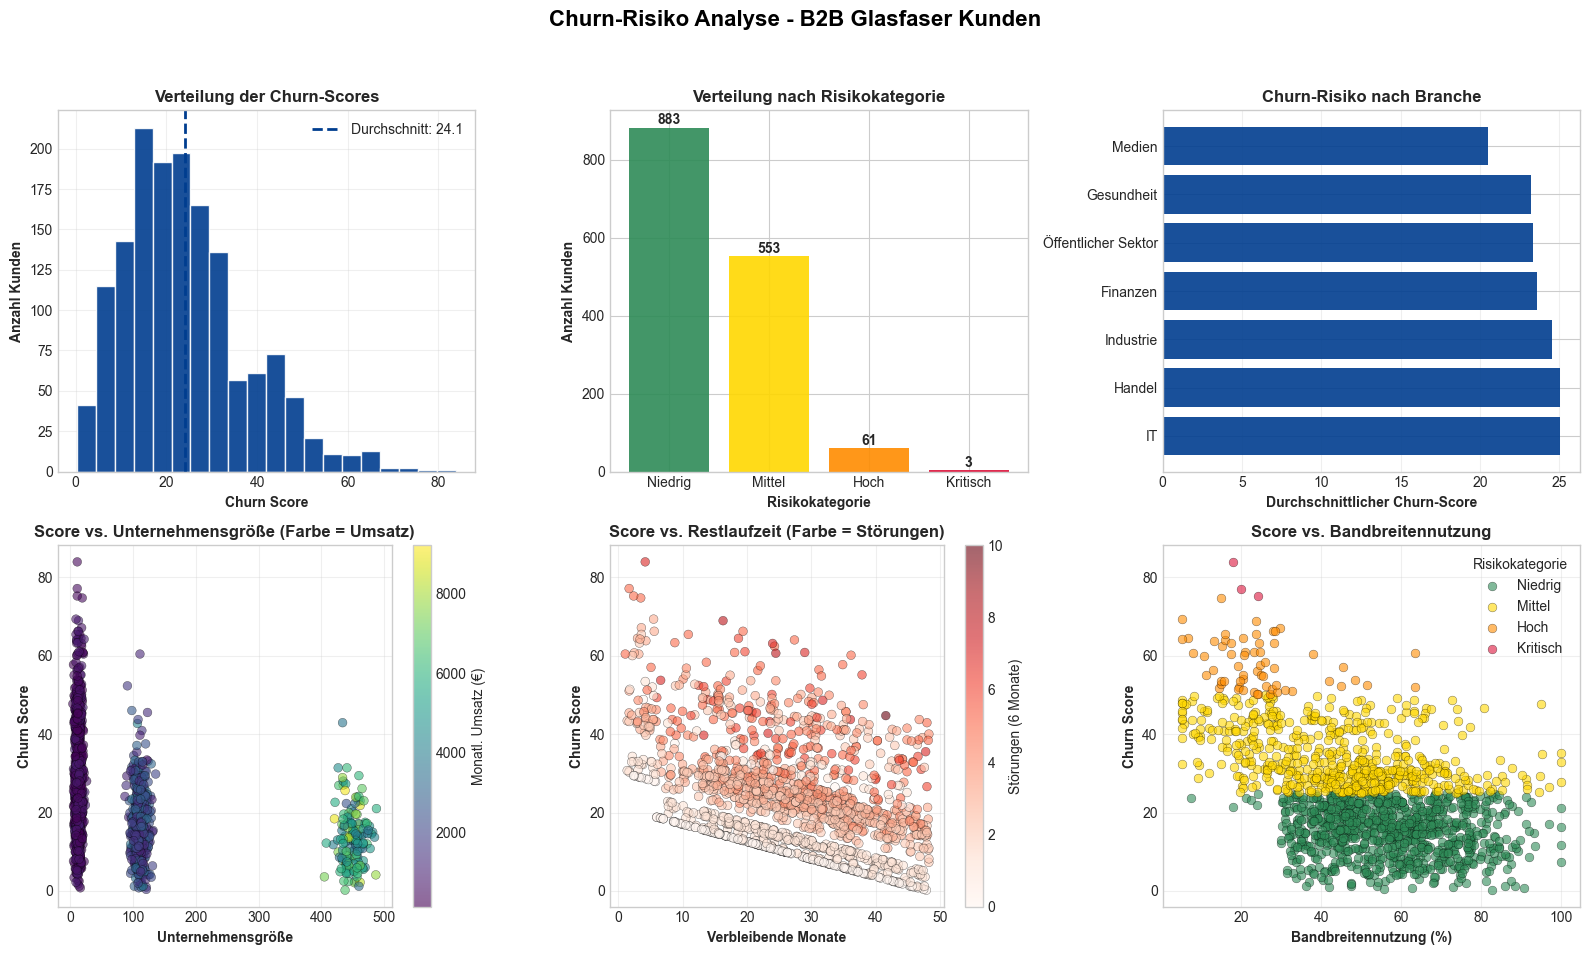

In [49]:
# Erklärung:
# - Erzeuge ein 2x3 Dashboard mit verschiedenen Plots, die die wichtigsten Insights zeigen.

fig = plt.figure(figsize=(16, 10))
fig.suptitle('Churn-Risiko Analyse - B2B Glasfaser Kunden', fontsize=16, fontweight='bold', color=CORPORATE_COLORS['secondary'])

# 1) Verteilung der Churn-Scores
ax1 = plt.subplot(2, 3, 1)
n, bins, patches = ax1.hist(df['churn_score'], bins=20, edgecolor='white', alpha=0.9)
ax1.axvline(df['churn_score'].mean(), color=CORPORATE_COLORS['primary'], linestyle='--', linewidth=2,
            label=f'Durchschnitt: {df["churn_score"].mean():.1f}')
ax1.set_xlabel('Churn Score', fontweight='bold')
ax1.set_ylabel('Anzahl Kunden', fontweight='bold')
ax1.set_title('Verteilung der Churn-Scores', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2) Risikokategorien (Balken)
ax2 = plt.subplot(2, 3, 2)
risk_counts = df['risikokategorie'].value_counts().reindex(['Niedrig','Mittel','Hoch','Kritisch']).fillna(0)
colors = [CORPORATE_COLORS['success'], '#FFD700', CORPORATE_COLORS['warning'], CORPORATE_COLORS['danger']]
bars = ax2.bar(risk_counts.index, risk_counts.values, color=colors, alpha=0.9)
ax2.set_xlabel('Risikokategorie', fontweight='bold')
ax2.set_ylabel('Anzahl Kunden', fontweight='bold')
ax2.set_title('Verteilung nach Risikokategorie', fontweight='bold')
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5, f'{int(height)}', ha='center', va='bottom', fontweight='bold')

# 3) Durchschnittlicher Score nach Branche (horizontal)
ax3 = plt.subplot(2, 3, 3)
branch_scores = df.groupby('Branche')['churn_score'].mean().sort_values(ascending=False)
y_pos = np.arange(len(branch_scores))
colors_branch = plt.cm.RdYlGn_r(branch_scores.values / 100)
ax3.barh(y_pos, branch_scores.values, color=CORPORATE_COLORS['primary'], alpha=0.9)
ax3.set_yticks(y_pos)
ax3.set_yticklabels(branch_scores.index)
ax3.set_xlabel('Durchschnittlicher Churn-Score', fontweight='bold')
ax3.set_title('Churn-Risiko nach Branche', fontweight='bold')
ax3.grid(True, alpha=0.3, axis='x')

# 4) Score vs Unternehmensgröße (Farbe = Umsatz)
ax4 = plt.subplot(2, 3, 4)
scatter = ax4.scatter(df['Unternehmensgröße'], df['churn_score'],
                      c=df['monatliche_Grundgebuehr'], cmap='viridis', alpha=0.6, s=40, edgecolor='k', linewidth=0.3)
ax4.set_xlabel('Unternehmensgröße', fontweight='bold')
ax4.set_ylabel('Churn Score', fontweight='bold')
ax4.set_title('Score vs. Unternehmensgröße (Farbe = Umsatz)', fontweight='bold')
ax4.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax4, label='Monatl. Umsatz (€)')

# 5) Verbleibende Laufzeit vs Score (Farbe = Störungen)
ax5 = plt.subplot(2, 3, 5)
scatter2 = ax5.scatter(df['verbleibende_Monate'], df['churn_score'],
                       c=df['Anzahl_technischer_Stoerungen_letzte_6M'], cmap='Reds', alpha=0.6, s=40, edgecolor='k', linewidth=0.3)
ax5.set_xlabel('Verbleibende Monate', fontweight='bold')
ax5.set_ylabel('Churn Score', fontweight='bold')
ax5.set_title('Score vs. Restlaufzeit (Farbe = Störungen)', fontweight='bold')
ax5.grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=ax5, label='Störungen (6 Monate)')

# 6) Nutzung vs Score nach Risikokategorie
ax6 = plt.subplot(2, 3, 6)
color_map = {'Niedrig': CORPORATE_COLORS['success'], 'Mittel': '#FFD700', 'Hoch': CORPORATE_COLORS['warning'], 'Kritisch': CORPORATE_COLORS['danger']}
for category, color in color_map.items():
    subset = df[df['risikokategorie'] == category]
    ax6.scatter(subset['durchschnittliche_Bandbreitennutzung_pct'], subset['churn_score'], label=category, alpha=0.6, s=40, color=color, edgecolor='k', linewidth=0.3)
ax6.set_xlabel('Bandbreitennutzung (%)', fontweight='bold')
ax6.set_ylabel('Churn Score', fontweight='bold')
ax6.set_title('Score vs. Bandbreitennutzung', fontweight='bold')
ax6.legend(title='Risikokategorie')
ax6.grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## 11. Handlungsempfehlungen, Priorisierung & Export

In [ ]:
# Erklärung:
# - Identifiziere Top-5 Kunden, formuliere Hauptrisikofaktoren und zwei konkrete Maßnahmen.
# - Erstelle eine priorisierte Kontaktliste (Terminvorschläge) und exportiere kritische Kunden.

print("HANDLUNGSEMPFEHLUNGEN FÜR DAS CUSTOMER SUCCESS TEAM")
print("=" * 80)

# Top-5 kritischste Kunden
top_5_critical = df.nlargest(5, 'churn_score').copy()
print("\nFünf Kunden mit höchstem Churn-Risiko:")
print("-" * 80)

for idx, row in top_5_critical.iterrows():
    print(f"\nKunde: {row['ID']}  | Branche: {row.get('Branche','-')}")
    print(f"  Churn-Score: {row['churn_score']:.1f} ({row['risikokategorie']})")
    print(f"  Monatlicher Umsatz: €{row['monatliche_Grundgebuehr']:,.0f}")
    print(f"  Verbleibende Laufzeit: {row['verbleibende_Monate']:.1f} Monate")
    # Sammle der 4 Hauptrisikofaktoren
    risikofaktoren = []
    if row['vertragsende_unter_6_monaten'] == 1:
        risikofaktoren.append(f"Vertragsende in {row['verbleibende_Monate']:.1f} Monaten")
    if row['Anzahl_technischer_Stoerungen_letzte_6M'] > 3:
        risikofaktoren.append(f"{int(row['Anzahl_technischer_Stoerungen_letzte_6M'])} technische Störungen")
    if row['durchschnittliche_Bandbreitennutzung_pct'] < THRESHOLDS['unterauslastung_pct']:
        risikofaktoren.append(f"Niedrige Nutzung: {row['durchschnittliche_Bandbreitennutzung_pct']:.0f}%")
    if row['Anzahl_Beschwerdeanrufe'] > 2:
        risikofaktoren.append(f"{int(row['Anzahl_Beschwerdeanrufe'])} Beschwerdeanrufe")
    if risikofaktoren:
        print("  Hauptrisikofaktoren:", "; ".join(risikofaktoren))

# Zwei konkrete Maßnahmen (kurz & prägnant)
print("\n" + "=" * 80)
print("ZWEI KONKRETE MASSNAHMEN")
print("=" * 80)
print("\nMassnahme 1: Proaktive Vertragsverlängerungs-Initiative")
print("  Zielgruppe: Kunden mit Vertragsende < 6 Monaten")
print("  Aktionen: Persönliche Kontaktaufnahme, individuelles Verlängerungsangebot, Treuebonus, technisches Review")
print("  Erwartete Wirkung: Reduktion der Kündigungen in dieser Gruppe um ca. 30-60%)")

print("\nMassnahme 2: Technische Optimierungs-Offensive")
print("  Zielgruppe: Kunden mit >3 Störungen in 6 Monaten")
print("  Aktionen: Netzwerk-Diagnose, präventive Wartung, Hardware-Upgrade-Angebote, dedizierter Support-Kanal")
print("  Erwartete Wirkung: Reduktion der Störungen und Verbesserung der Zufriedenheit")

# Priorisierungsliste (Top 10 nach prioritaet)
priority_df = df.sort_values('prioritaet', ascending=False).head(10)[[
    'ID', 'Branche', 'churn_score', 'prioritaet', 'verbleibende_Monate', 'monatliche_Grundgebuehr'
]].copy()
# Erzeugt eine Folge von Terminvorschlägen, beginnend am 15.12.2024, im Abstand von jeweils 2 Tagen
'''
Ziel: Sofort umsetzbare Termine finden, die Kontakte zeitlich zu verteilen (z. B. um Ressourcenengpässe zu vermeiden) und die Liste operational zu machen
'''
priority_df['Kontaktzeitpunkt'] = pd.date_range(start='2024-12-15', periods=len(priority_df), freq='2D').strftime('%d.%m.%Y') 
priority_df['Empfohlene_Massnahme'] = priority_df['verbleibende_Monate'].apply(
    lambda x: 'Vertragsverlängerung + Technisches Review' if x < 6 else 'Technische Optimierung + Beschwerdemanagement'
)
print("\nPriorisierte Kontaktliste (Top 10):")
display(priority_df)

# Export kritischer Kunden (Score >= 50)
export_df = df[df['churn_score'] >= THRESHOLDS['hoch_score']][[
    'ID', 'Branche', 'churn_score', 'risikokategorie', 'verbleibende_Monate',
    'monatliche_Grundgebuehr', 'Anzahl_technischer_Stoerungen_letzte_6M',
    'durchschnittliche_Bandbreitennutzung_pct', 'Anzahl_Beschwerdeanrufe', 'prioritaet'
]].sort_values('churn_score', ascending=False)

# Zusammenfassung
print("\n" + "=" * 80)
print("ANALYSE ZUSAMMENGEFASST")
print("=" * 80)
print(f"Gesamtzahl analysierter Kunden: {len(df)}")
print(f"Kritische Kunden (Score ≥ {THRESHOLDS['kritisch_score']}): {len(df[df['churn_score'] >= THRESHOLDS['kritisch_score']])}")
print(f"Hochrisiko-Kunden (Score ≥ {THRESHOLDS['hoch_score']}): {len(export_df)}")
print(f"Durchschnittlicher Churn-Score: {df['churn_score'].mean():.1f}")
print(f"Monatlicher Umsatz gefährdet (Score ≥ {THRESHOLDS['hoch_score']}): €{export_df['monatliche_Grundgebuehr'].sum():,.0f}")
print(f"Jahresumsatz gefährdet (Score ≥ {THRESHOLDS['hoch_score']}): €{export_df['monatliche_Grundgebuehr'].sum() * 12:,.0f}")

# Speichern des Outputs
OUTPUT_DIR = "Output"
os.makedirs(OUTPUT_DIR, exist_ok=True)  # erstellt Ordner, falls noch nicht vorhanden
# 1) CSV speichern 
csv_path = os.path.join(OUTPUT_DIR, "churn_risiko_analyse.csv")
export_df.to_csv(csv_path, index=False, encoding="utf-8-sig")
# Inline-Kommentar: export_df enthält alle Kunden mit churn_score >= THRESHOLDS['hoch_score']

# 2) Gesamtes Dashboard als PNG speichern
dashboard_png = os.path.join(OUTPUT_DIR, "dashboard_overview.png")
try:
    fig.savefig(dashboard_png, dpi=300, bbox_inches="tight")
except NameError:
    # fallback: aktuelle Matplotlib-Figure speichern
    import matplotlib.pyplot as plt
    plt.gcf().savefig(dashboard_png, dpi=300, bbox_inches="tight")


HANDLUNGSEMPFEHLUNGEN FÜR DAS CUSTOMER SUCCESS TEAM

Fünf Kunden mit höchstem Churn-Risiko:
--------------------------------------------------------------------------------

Kunde: CUST0461  | Branche: Öffentlicher Sektor
  Churn-Score: 83.9 (Kritisch)
  Monatlicher Umsatz: €279
  Verbleibende Laufzeit: 4.2 Monate
  Hauptrisikofaktoren: Vertragsende in 4.2 Monaten; 7 technische Störungen; Niedrige Nutzung: 18%; 3 Beschwerdeanrufe

Kunde: CUST0776  | Branche: Handel
  Churn-Score: 77.1 (Kritisch)
  Monatlicher Umsatz: €367
  Verbleibende Laufzeit: 1.7 Monate
  Hauptrisikofaktoren: Vertragsende in 1.7 Monaten; 5 technische Störungen; Niedrige Nutzung: 20%; 3 Beschwerdeanrufe

Kunde: CUST0709  | Branche: Handel
  Churn-Score: 75.2 (Kritisch)
  Monatlicher Umsatz: €307
  Verbleibende Laufzeit: 2.4 Monate
  Hauptrisikofaktoren: Vertragsende in 2.4 Monaten; 5 technische Störungen; Niedrige Nutzung: 24%

Kunde: CUST0265  | Branche: IT
  Churn-Score: 74.7 (Hoch)
  Monatlicher Umsatz: €348
  Ve

,ID,Branche,churn_score,prioritaet,verbleibende_Monate,monatliche_Grundgebuehr,Kontaktzeitpunkt,Empfohlene_Massnahme
1347,CUST1348,Finanzen,25.60,232.35,24.00,9076,15.12.2024,Technische Optimierung + Beschwerdemanagement
1397,CUST1398,Industrie,28.90,223.40,3.60,7730,17.12.2024,Vertragsverlängerung + Technisches Review
590,CUST0591,IT,27.00,209.57,18.00,7762,19.12.2024,Technische Optimierung + Beschwerdemanagement
319,CUST0320,Öffentlicher Sektor,31.40,193.27,5.40,6155,21.12.2024,Vertragsverlängerung + Technisches Review
769,CUST0770,Finanzen,21.80,189.01,16.10,8670,23.12.2024,Technische Optimierung + Beschwerdemanagement
871,CUST0872,Industrie,23.90,186.90,25.40,7820,25.12.2024,Technische Optimierung + Beschwerdemanagement
202,CUST0203,Gesundheit,26.10,182.20,7.40,6981,27.12.2024,Technische Optimierung + Beschwerdemanagement
1497,CUST1498,IT,29.40,178.75,2.40,6080,29.12.2024,Vertragsverlängerung + Technisches Review
657,CUST0658,IT,26.90,175.15,18.10,6511,31.12.2024,Technische Optimierung + Beschwerdemanagement
666,CUST0667,Finanzen,42.70,175.11,4.70,4101,02.01.2025,Vertragsverlängerung + Technisches Review



ANALYSE ZUSAMMENGEFASST
Gesamtzahl analysierter Kunden: 1500
Kritische Kunden (Score ≥ 75): 3
Hochrisiko-Kunden (Score ≥ 50): 64
Durchschnittlicher Churn-Score: 24.1
Monatlicher Umsatz gefährdet (Score ≥ 50): €36,348
Jahresumsatz gefährdet (Score ≥ 50): €436,176
